# Import libraries

In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
from tqdm import tqdm
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd

In [2]:
!pip install prophet

# Data cleaning

In [3]:
holidays = pd.read_csv("holidays.csv")

In [4]:
df = pd.read_excel('/content/TPS IN.xlsx')
df = df.iloc[104:]
voix = df[['DATES','TPS_VOIX']]
voix.dropna(inplace= True)

<ipython-input-4-a94c752dc3eb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voix.dropna(inplace= True)


Text(0, 0.5, 'TPS_VOIX')

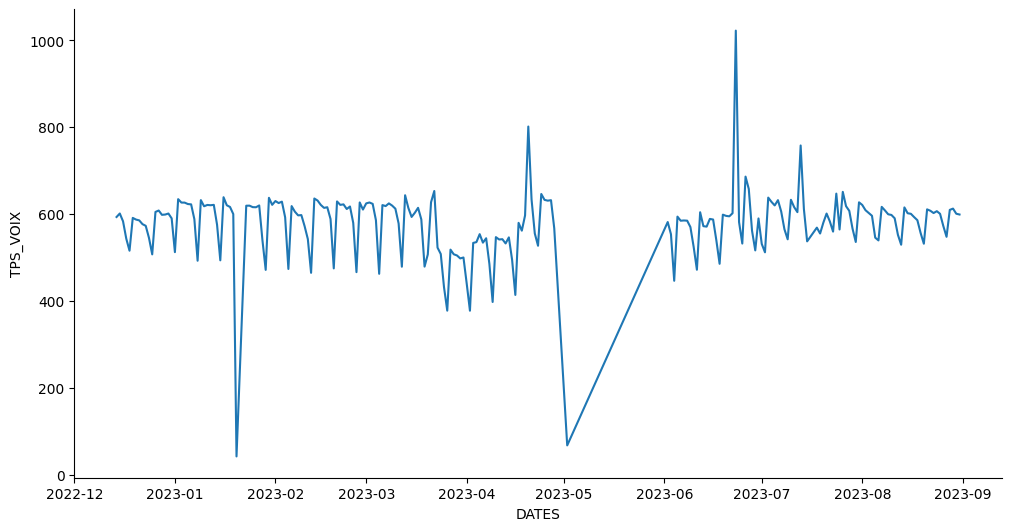

In [5]:

def _plot_series(series, series_name, series_index=0):
  xs = series['DATES']
  ys = series['TPS_VOIX']

  plt.plot(xs, ys, label=series_name)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = voix.sort_values('DATES', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATES')
plt.ylabel('TPS_VOIX')

In [44]:
# Data cleaning using  the interquartile range (IQR) method
voix = df[['DATES','TPS_VOIX']]
voix.dropna(inplace= True)
voix.columns = ['ds','y']
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = voix['y'].quantile(0.25)
Q3 = voix['y'].quantile(0.75)
print(Q1,Q3)
# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the outlier threshold
threshold = 1.5
# Identify outliers
outliers = voix[(voix['y'] < Q1 - threshold * IQR) | (voix['y'] > Q3 + threshold * IQR)]

# delete outliers
#voix = voix[~voix.index.isin(outliers.index)]

# Replace outliers with median value
median_value = voix['y'].median()
voix['y'].loc[outliers.index] = median_value

544.4224999999999 618.575


<ipython-input-44-93ab70f556b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voix.dropna(inplace= True)
<ipython-input-44-93ab70f556b3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voix['y'].loc[outliers.index] = median_value


(0.0, 1000.0)

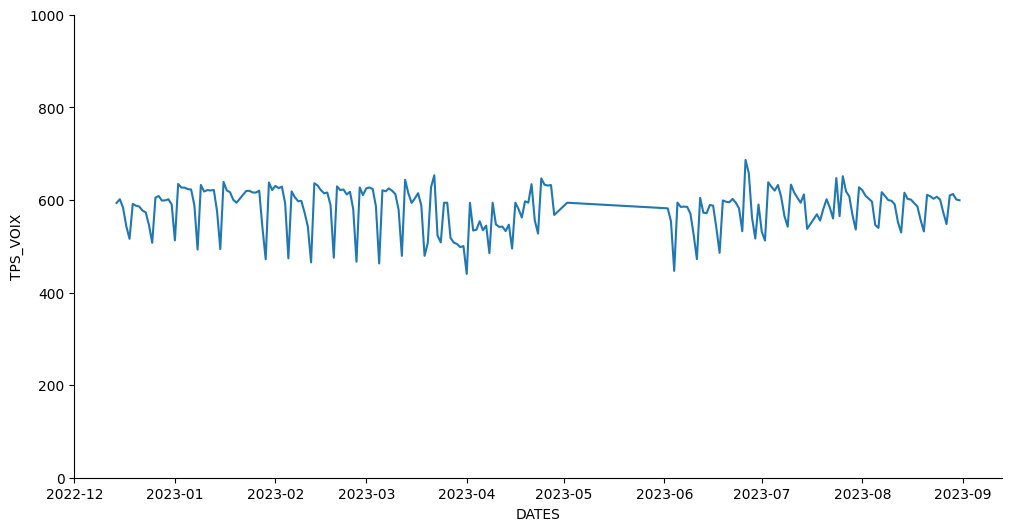

In [43]:
def _plot_series(series, series_name, series_index=0):
  xs = series['ds']
  ys = series['y']

  plt.plot(xs, ys, label=series_name)

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
_plot_series(voix, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATES')
plt.ylabel('TPS_VOIX')
plt.ylim(0, 1000)

In [48]:
# split the data
train_percentage = 0.8
train_size = int(len(voix) * train_percentage)
train_voix = voix.iloc[:train_size]
test_voix = voix.iloc[train_size:]

In [49]:

holidays = pd.read_csv("holidays.csv")
model = Prophet(
                      growth='linear',

                     changepoint_range=0.7,
                     holidays=holidays,
                     seasonality_mode='additive',
                     seasonality_prior_scale=0.6,
                     holidays_prior_scale=1.0,
                     changepoint_prior_scale=0.3,
)
model.fit(train_voix)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxqxxi1d3/jvr9yvhy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxqxxi1d3/az5fet43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81870', 'data', 'file=/tmp/tmpxqxxi1d3/jvr9yvhy.json', 'init=/tmp/tmpxqxxi1d3/az5fet43.json', 'output', 'file=/tmp/tmpxqxxi1d3/prophet_modelfg6i_7pl/prophet_model-20240317145448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:54:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:54:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [50]:
start_date = '2023-09-01'
end_date = pd.to_datetime(start_date) + pd.DateOffset(months=3) - pd.DateOffset(days=1)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
future = pd.DataFrame({'ds': date_range})
print(future)

           ds
0  2023-09-01
1  2023-09-02
2  2023-09-03
3  2023-09-04
4  2023-09-05
..        ...
86 2023-11-26
87 2023-11-27
88 2023-11-28
89 2023-11-29
90 2023-11-30

[91 rows x 1 columns]


In [51]:
test_forecast = model.predict(test_voix[['ds']])
test_predictions = test_forecast[['yhat']]
actual_values = test_voix['y'].values

In [52]:

mae = mean_absolute_error(actual_values, test_predictions)
mse = mean_squared_error(actual_values, test_predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 33.876469774097714
Mean Squared Error (MSE): 1620.7393304722789
Root Mean Squared Error (RMSE): 40.25840695398017


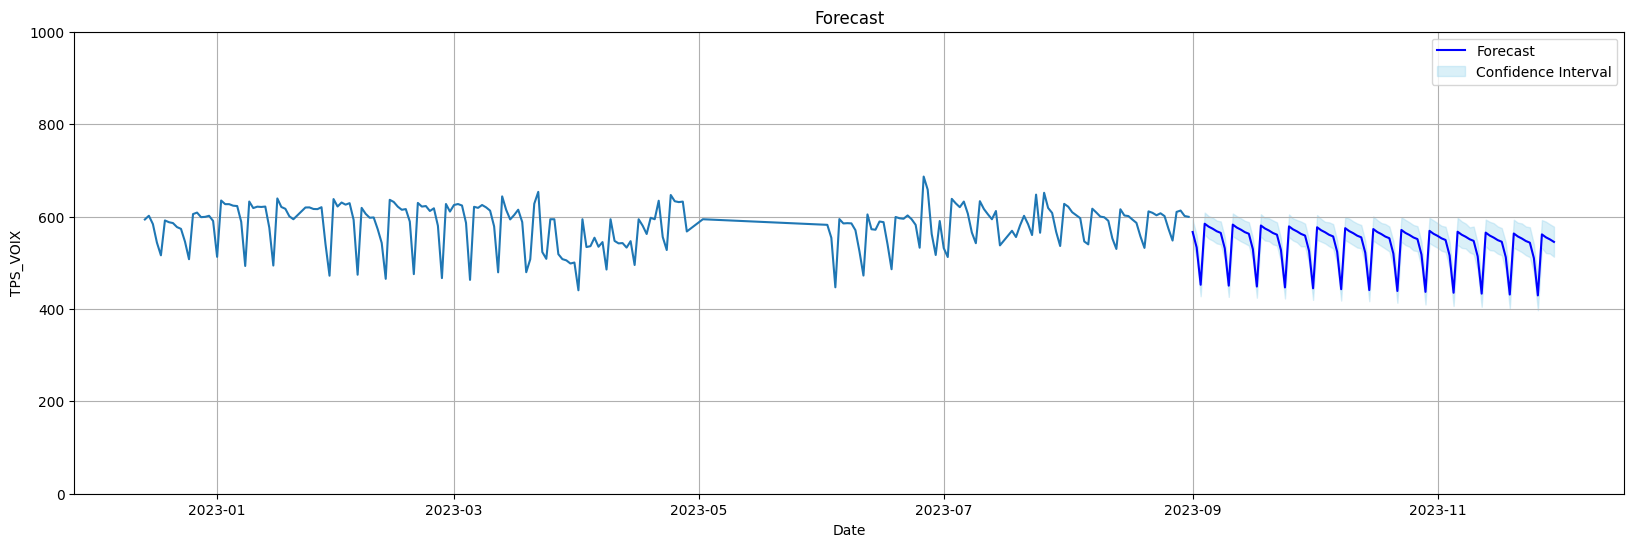

In [54]:
forecast = model.predict(future)
date_range = forecast['ds']
forecasted_values = forecast['yhat']
lower_bound = forecast['yhat_lower']
upper_bound = forecast['yhat_upper']
plt.figure(figsize=(20, 6))
plt.plot(date_range, forecasted_values, label='Forecast', color='blue')
plt.fill_between(date_range, lower_bound, upper_bound, color='skyblue', alpha=0.3, label='Confidence Interval')
plt.plot(voix['ds'],voix['y'])
plt.xlabel('Date')
plt.ylabel('TPS_VOIX')
plt.title('Forecast')
plt.legend()
plt.grid(True)
plt.ylim(0,1000)
plt.show()

# Fine Tuning

In [ ]:


param_grid = {
    'growth': ['linear'],
    'n_changepoints': [0,2,4,6,10],
    'changepoint_range': [0.8, 0.9],
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [0.5, 0.8, 1.0],
    'holidays_prior_scale': [0.8, 1.0, 1.2],
    'changepoint_prior_scale': [0.05, 0.1, 0.2],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross-validation to evaluate all parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = 0.0

with tqdm(total=len(all_params), desc="Tuning progress") as pbar:
    for i, params in enumerate(all_params):
        m = Prophet(**params).fit(voix)  # Fit model with given params
        df_cv = cross_validation(m, horizon='45 days', parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        tuning_results.at[i, 'rmse'] = df_p['rmse'].values[0]
        pbar.update(1)

# Find the best parameters
best_params_index = tuning_results['rmse'].idxmin()
best_params = tuning_results.iloc[best_params_index]
print("Best Parameters:")
print(best_params)


In [56]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'growth': 'linear', 'n_changepoints': 6, 'changepoint_range': 0.9, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.8, 'changepoint_prior_scale': 0.1}


In [59]:
model = Prophet(**best_params)
model.fit(train_voix)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxqxxi1d3/pxn9dtq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxqxxi1d3/a02etwf_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63746', 'data', 'file=/tmp/tmpxqxxi1d3/pxn9dtq0.json', 'init=/tmp/tmpxqxxi1d3/a02etwf_.json', 'output', 'file=/tmp/tmpxqxxi1d3/prophet_modelmtg9t9k5/prophet_model-20240317152327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [60]:
test_forecast = model.predict(test_voix[['ds']])
test_predictions = test_forecast[['yhat']]
actual_values = test_voix['y'].values

In [61]:
mae = mean_absolute_error(actual_values, test_predictions)
mse = mean_squared_error(actual_values, test_predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 16.35006621612577
Mean Squared Error (MSE): 420.00060932854103
Root Mean Squared Error (RMSE): 20.493916398007997


In [62]:
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

           ds        yhat  yhat_lower  yhat_upper
86 2023-11-26  547.382836  485.271706  604.618649
87 2023-11-27  657.263410  589.481039  720.619606
88 2023-11-28  651.000921  586.438692  712.256443
89 2023-11-29  647.523374  584.596273  710.989782
90 2023-11-30  638.798267  576.238424  694.710706


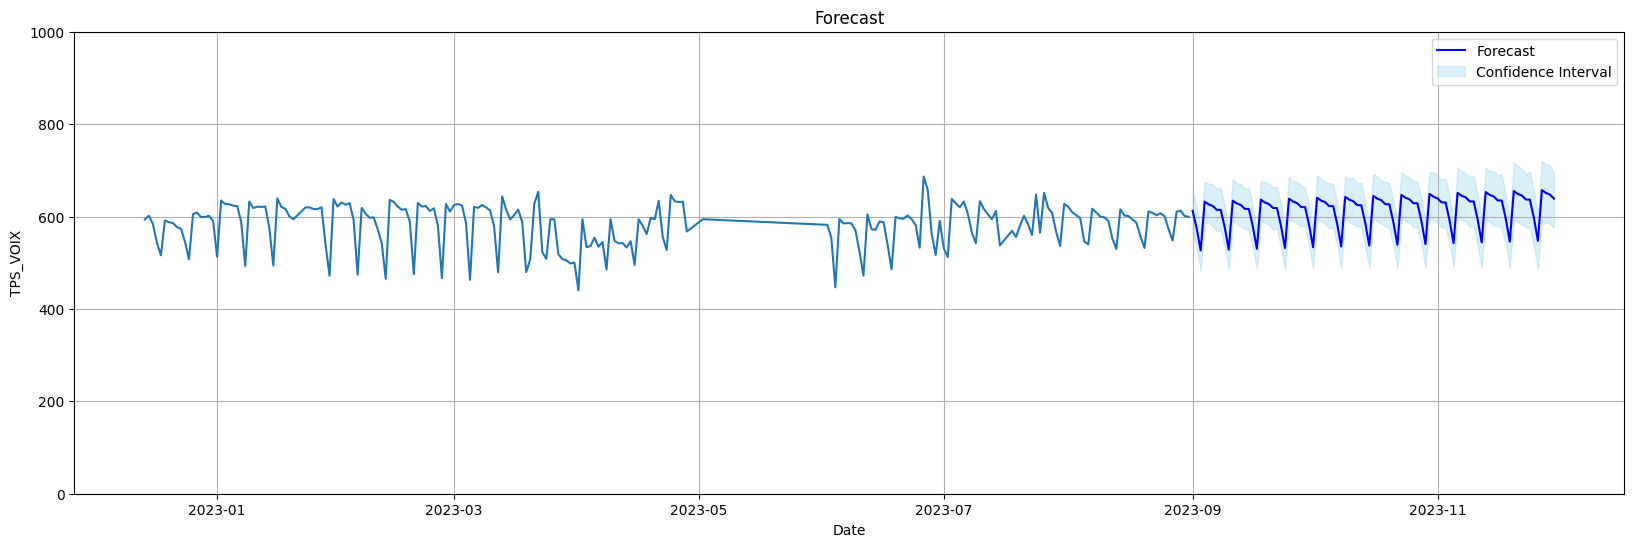

In [64]:
date_range = forecast['ds']
forecasted_values = forecast['yhat']
lower_bound = forecast['yhat_lower']
upper_bound = forecast['yhat_upper']
plt.figure(figsize=(20, 6))
plt.plot(date_range, forecasted_values, label='Forecast', color='blue')
plt.fill_between(date_range, lower_bound, upper_bound, color='skyblue', alpha=0.3, label='Confidence Interval')
plt.plot(voix['ds'],voix['y'])
plt.xlabel('Date')
plt.ylabel('TPS_VOIX')
plt.title('Forecast')
plt.legend()
plt.grid(True)
plt.ylim(0,1000)
plt.show()